# Imports and Functions

## terminal commands for data access

```
autossh -AtX vschuma@ssh1.mdc-berlin.de ssh vschuma@murphy.mdc-berlin.net
# open the ssh screen and/or type
ssh -NR 6667:localhost:22 vfs@79.197.179.128 (current network ID)

# mount
sshfs -p 6667 vschuma@localhost:/data/local/rajewsky/home/vschuma /mnt/murphy_workspace/
or
sshfs vschuma@murphy:/data/local/rajewsky/home/vschuma/ ~/mounts/murphy_workspace/

# if working with the mount is to slow, copy the data to a ramdisk
sudo mount -t tmpfs -o size=6g tmpfs /mnt/ramdisk/

# then copy the file to the ramdisk
mkdir /mnt/ramdisk/data && rsync -av /mnt/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /mnt/ramdisk/data
or
mkdir /dev/shm/data && rsync -av /home/vschuma/mounts/murphy_workspace/NSTT/data/GarciaAlsono_uterus/hot_data/* /dev/shm/data/
# symlink inside the pycharm project to the data dir
(example command)
ln -s /mnt/ramdisk/data data
e.g.: ln -s /mnt/murphy_workspace/NSTT/data/ data
or
ln -s /dev/shm/data/ data
```

In [2]:
from importlib import reload

import anndata
%matplotlib inline

import importlib.util
import sys
spec = importlib.util.spec_from_file_location("novosparc", "/home/vfs/PycharmProjects/rajewskyLab/novosparc/novosparc/__init__.py")
# spec = importlib.util.spec_from_file_location("novosparc", "/home/vschuma/PycharmProjects/novosparc/novosparc/__init__.py")
novosparc = importlib.util.module_from_spec(spec)
sys.modules["novosparc"] = novosparc
spec.loader.exec_module(novosparc)

# import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.viridis()
from matplotlib.gridspec import GridSpec

from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import zscore
import sklearn
from sklearn.preprocessing import scale
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import random

<Figure size 432x288 with 0 Axes>

## Correlation measurement functions

In [3]:
def mse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.square(np.subtract(actual,pred)).mean()

def rmse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

def mean_pearson(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = pearsonr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def mean_spearman(actual, pred):
    r_per_gene = []
    for i in range(actual.shape[1]):
        r_score,p_value = spearmanr(actual[:,i],
                 pred[:,i])
        r_per_gene.append(r_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return r_per_gene, np.mean(r_per_gene)

def box_swarm_label(plot_df, score_name, single_dfs=None):
    ## plot_df must contain columns "gene", "r score (pearson)", and "method" (being the  reconstruction/cleaning)

    figure(figsize=(11, 12), dpi=80)

    sns.boxplot(x="method", y=score_name, data=plot_df, whis=np.inf)
    sns.swarmplot(x="method", y=score_name, data=plot_df,
                  palette=["crimson","indigo"])

    if single_dfs:
        for counter, single_df in enumerate(single_dfs):

            for x,y, label in zip([counter]*len(plot_df), single_df[score_name], single_df["gene"]):
                plt.text(x = x + 0.1, y = y,
                         s = label,
                         rotation= 45)
    plt.show()

def filter_matrix_for_genes(dataframe, gene_list):
    filtered_df = dataframe[dataframe.gene.isin(gene_list)]
    return filtered_df

def mean_ssim(actual, pred):
    ssim_per_gene = []
    for i in range(actual.shape[1]):
        ssim_score= ssim(actual[:,i],pred[:,i],
                         data_range= pred[:,i].max() -  pred[:,i].min())
        ssim_per_gene.append(ssim_score) # assumption all p-values are acceptable ToDo: make version with filtering for p-values
    return ssim_per_gene, np.mean(ssim_per_gene)
# def invest_plot_for_correlations(truth_df, list_of_expression_mtrx, list_of_special_genes, list_of_score_cutoffs)
# ToDo
plt.viridis()

<Figure size 432x288 with 0 Axes>

# Data - Read in data and atlas

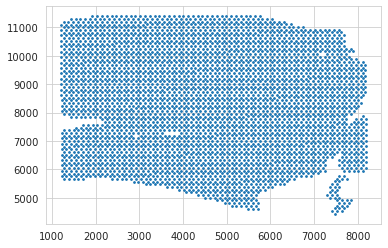

In [4]:
# atlas settings
atlas_dir = 'data'
target_space_path = os.path.join(atlas_dir, 'endometr_coordinates.txt')
locations = pd.read_csv(target_space_path, sep='\t')

num_locations = 3871 # coming from the spatial data
locations_apriori = locations[:num_locations][['x', 'y']]
locations = np.asarray(locations_apriori)
plt.scatter(locations[:, 0], locations[:, 1], s=3)

## Reading in spatially informative gene atlas

In [6]:
atlas_path = os.path.join(atlas_dir, 'uterus_GarciaAlsonso_atlas_spatial_info_dge.csv')
# atlas = sc.read_csv(atlas_path, delimiter=',') # this always through a Value Error about unmatching column numbers - idea why

chunks = pd.read_csv(atlas_path, index_col=0, chunksize=1000000)
df = pd.concat(chunks)
atlas = sc.AnnData(df)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

/tmp/ipykernel_36007/2027063284.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atlas = sc.AnnData(df)
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Reconstruction

## Reading in single cell data

In [24]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'data/'
data_path = os.path.join(data_dir, 'adata_ti_sec_2_sample_normalized_dge.csv')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
num_cells, num_genes = dataset.shape
print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)
# optional: subset cells
num_cells = 500
sc.pp.subsample(dataset, n_obs=num_cells)
# dge_rep mode
dge_rep = None  # a representation of cells gene expression

number of cells: 2368
number of genes: 28614


## Reconstruction linear and smooth, alpha = 0.8, neighbours = 5

In [25]:
# calculate cost matrix
# params for smooth cost # only needed when/for the part where you don't use the atlas!
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


# setup smooth
num_neighbors_s = num_neighbors_t = 5

# alternative 1: setup both assumptions
tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# alternative 2: use atlas only
# tissue.setup_linear_cost(markers_to_use, atlas_matrix)

# tissue_postcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue.sdge

dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

Setting up for reconstruction ... 

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 5.55 seconds )
Reconstructing spatial information with 77 markers: 500 cells and 3871 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


/tmp/ipykernel_36007/2676004951.py:38: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


## Set truth expression matrix

In [26]:
subset_cols = []
for i, gene in enumerate(markers):
    if gene in dataset_reconst.var_names:
        subset_cols.append(np.asarray(atlas[:, gene].X).reshape(-1, 1))
exprmtrx_truth = np.concatenate(subset_cols, axis=1)

## Set reconstruction expression matrix

In [27]:
subset_cols = []
for i, gene in enumerate(atlas_genes):
    if gene in dataset_reconst.var_names:
        subset_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1, 1))
exprmtrx_simplerecon = np.concatenate(subset_cols, axis=1)

## GMM clean - default settings

In [28]:
# GMM
tissue.cleaning_expression_data(dataset_reconst,tissue.sdge.T,normalization='zscore', selected_genes=atlas_genes)
# reconstructed expression of individual genes
sdge_postcleaned = tissue.cleaned_dge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations

Expression array contained all-0 columns, which where removed
Expression array contained all-0 columns, which where removed
Expression array contained all-0 columns, which where removed
Expression array contained all-0 columns, which where removed
Expression array contained all-0 columns, which where removed
Expression array contained all-0 columns, which where removed


/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
 

## Set cleaning expression matrix

In [29]:
subset_cols = []
for i, gene in enumerate(atlas_genes):
    if gene in dataset_reconst_postcleaned.var_names:
        subset_cols.append(np.asarray(dataset_reconst_postcleaned[:, gene].X).reshape(-1, 1))
exprmtrx_recon_defaultGMM = np.concatenate(subset_cols, axis=1)

# Comparing Results

## Merging matrix and scale together

In [31]:
exprssn_mtrx_all = np.concatenate((exprmtrx_truth, exprmtrx_simplerecon, exprmtrx_recon_defaultGMM), axis=1)
print(exprmtrx_truth.shape)
print(exprmtrx_simplerecon.shape)
print(exprmtrx_recon_defaultGMM.shape)
print(exprssn_mtrx_all.shape)

(3871, 77)
(3871, 77)
(3871, 77)
(3871, 231)


In [32]:
# ToDo this should be a function where the split values are dynamically adjusted to the length of the array
exprssn_mtrx_all_scaled = scale(exprssn_mtrx_all)
expmtrx_truth_scaled = exprssn_mtrx_all_scaled[:,0:77]
exprmtrx_simplerecon_scaled = exprssn_mtrx_all_scaled[:,77:154]
exprmtrx_recon_defaultGMM_scaled = exprssn_mtrx_all_scaled[:,154:231]

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


## boxplots

median pearson; recon: nan, clean:nan


/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<Figure size 432x288 with 0 Axes>

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


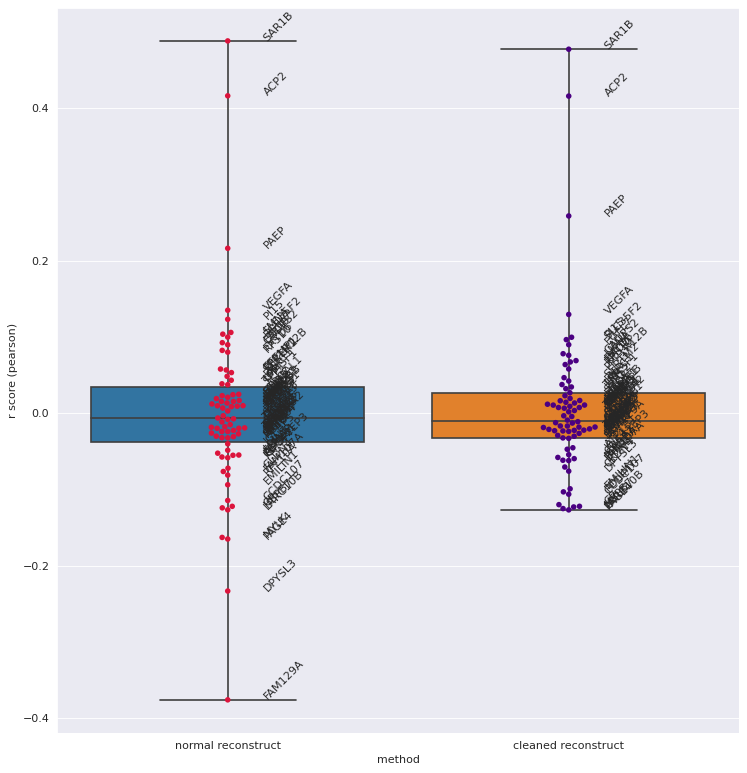

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


median spearman; recon: nan, clean:nan


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


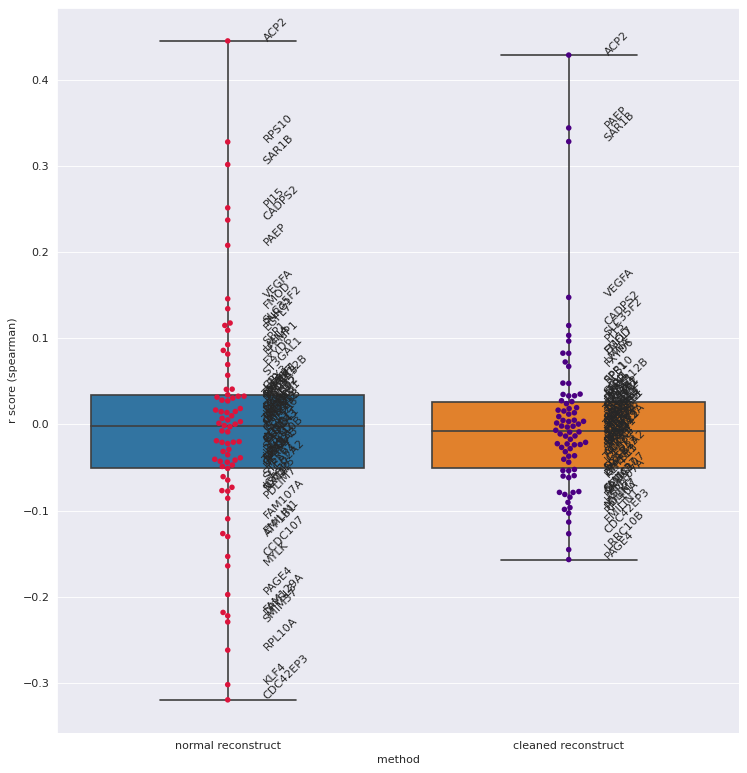

median cosine similarity; recon: -0.0034359130077064037, clean:-0.0043793609365820885


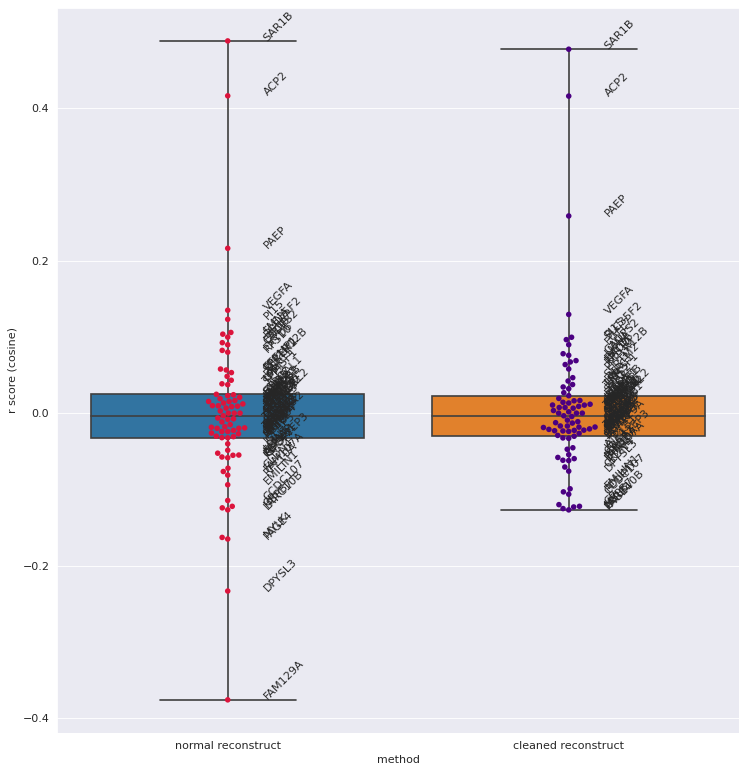

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in true_divide
  S = (A1 * A2) / D
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/skimage/metrics/_structural_similarity.py:230: RuntimeWarning: invalid value encountered in true_divide
  S = (A1 * A2) / D
posx and posy should be finite values


SSM none: 1.0
SSM reconstruction: 0.3589393514924881
SSM cleaning: 0.29805927093492074
median ssim gene-wise; recon: nan, clean:nan


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


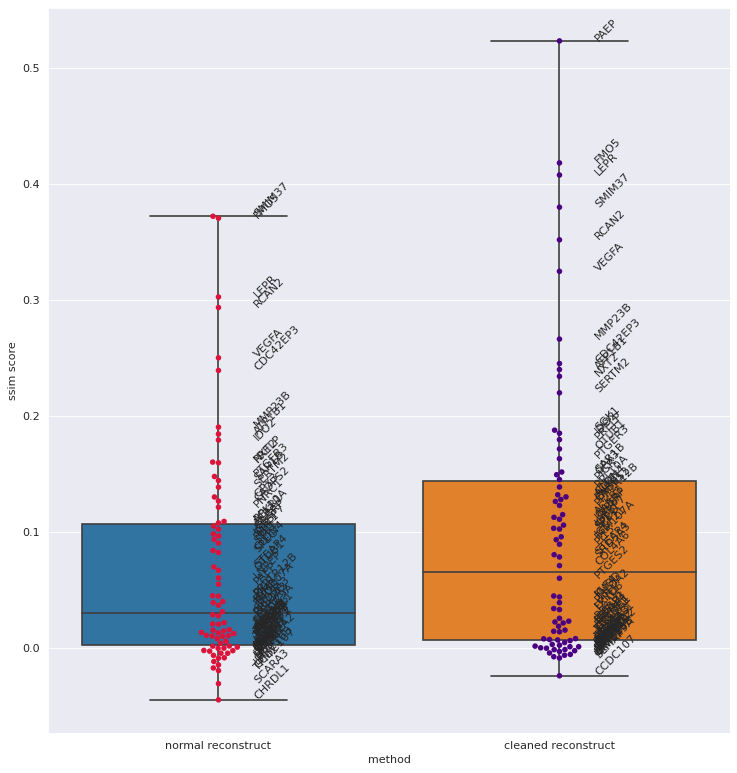

In [34]:
plt.viridis()
# pearson
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_pearson(expmtrx_truth_scaled, exprmtrx_simplerecon_scaled)
pearson_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes, r_values_recon, method_recon)),
                                            columns=["gene", "r score (pearson)", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
r_values_clean, mean_corre_clean = mean_pearson(expmtrx_truth_scaled, exprmtrx_recon_defaultGMM_scaled)
pearson_corre_cleaned = pd.DataFrame(list(zip(atlas_genes, r_values_clean, method_clean)),
                                     columns=["gene", "r score (pearson)", "method"])

print(f"median pearson; recon: {np.median(r_values_recon)}, clean:{np.median(r_values_clean)}")
pearson_corre_plt = pd.concat([pearson_corre_reconstruction, pearson_corre_cleaned])
box_swarm_label(pearson_corre_plt, "r score (pearson)",
                [pearson_corre_reconstruction, pearson_corre_cleaned])

# spearman
method_recon = ["normal reconstruct"] * len(atlas_genes)
r_values_recon, mean_corre_recon = mean_spearman(expmtrx_truth_scaled, exprmtrx_simplerecon_scaled)
spearman_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes,r_values_recon, method_recon)),
                                    columns=["gene","r score (spearman)","method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
r_values_clean, mean_corre_clean = mean_spearman(expmtrx_truth_scaled, exprmtrx_recon_defaultGMM_scaled)
spearman_corre_cleaned = pd.DataFrame(list(zip(atlas_genes,r_values_clean, method_clean)),
                                    columns=["gene","r score (spearman)","method"])

print(f"median spearman; recon: {np.median(r_values_recon)}, clean:{np.median(r_values_clean)}")
spearman_corre_plt = pd.concat([spearman_corre_reconstruction,spearman_corre_cleaned])
box_swarm_label(spearman_corre_plt,
                "r score (spearman)",
                [spearman_corre_reconstruction,spearman_corre_cleaned])



# cosine
method_recon = ["normal reconstruct"] * len(atlas_genes)
cosin_sim_values_recon = sklearn.metrics.pairwise.cosine_similarity(expmtrx_truth_scaled.T, exprmtrx_simplerecon_scaled.T)
cosin_sim_values_recon_diag = np.diag(cosin_sim_values_recon)
cosin_corre_reconstruction = pd.DataFrame(list(zip(atlas_genes, cosin_sim_values_recon_diag, method_recon)),
                                          columns=["gene", "r score (cosine)", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
cosin_sim_values_clean = sklearn.metrics.pairwise.cosine_similarity(expmtrx_truth_scaled.T, exprmtrx_recon_defaultGMM_scaled.T)
cosin_sim_values_clean_diag = np.diag(cosin_sim_values_clean)
cosin_corre_cleaned = pd.DataFrame(list(zip(atlas_genes, cosin_sim_values_clean_diag, method_clean)),
                                   columns=["gene", "r score (cosine)", "method"])

print(f"median cosine similarity; recon: {np.median(cosin_sim_values_recon_diag)}, "
      f"clean:{np.median(cosin_sim_values_clean_diag)}")
cosine_corre_plt = pd.concat([cosin_corre_reconstruction, cosin_corre_cleaned])
box_swarm_label(cosine_corre_plt,
                "r score (cosine)",
                [cosin_corre_reconstruction, cosin_corre_cleaned])

# ssim - general

img = expmtrx_truth_scaled
img_noise = exprmtrx_simplerecon_scaled
img_const = exprmtrx_recon_defaultGMM_scaled

mse_none = mean_squared_error(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())
print("SSM none:",ssim_none)

mse_noise = mean_squared_error(img, img_noise)
ssim_noise = ssim(img, img_noise, data_range=img_noise.max() - img_noise.min())
print("SSM reconstruction:", ssim_noise)

mse_const = mean_squared_error(img, img_const)
ssim_const = ssim(img, img_const, data_range=img_const.max() - img_const.min())

print("SSM cleaning:", ssim_const)
# ssim - per gene

method_recon = ["normal reconstruct"] * len(atlas_genes)
ssim_values_recon, mean_ssim_recon = mean_ssim(expmtrx_truth_scaled, exprmtrx_simplerecon_scaled)

ssim_reconstruction = pd.DataFrame(list(zip(atlas_genes, ssim_values_recon, method_recon)),
                                          columns=["gene", "ssim score", "method"])

method_clean = ["cleaned reconstruct"] * len(atlas_genes)
ssim_values_clean, mean_ssim_clean = mean_ssim(expmtrx_truth_scaled, exprmtrx_recon_defaultGMM_scaled)
ssim_cleaned = pd.DataFrame(list(zip(atlas_genes, ssim_values_clean, method_clean)),
                                   columns=["gene", "ssim score", "method"])

print(f"median ssim gene-wise; recon: {np.median(ssim_values_recon)}, clean:{np.median(ssim_values_clean)}")
ssim_plt = pd.concat([ssim_reconstruction, ssim_cleaned])
box_swarm_label(ssim_plt,
                "ssim score",
                [ssim_reconstruction, ssim_cleaned])